In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import PIL
import cv2
import os

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=20,
    shear_range=10,
    validation_split=0.2)

In [3]:
train_generator = train_datagen.flow_from_directory(
    './images/',
    target_size=(28, 28),
    batch_size = 32,
    class_mode='categorical',
    subset='training') # set as training data

val_generator = train_datagen.flow_from_directory(
    './images/', # same directory as training data
    target_size=(28, 28),
    class_mode='categorical',
    batch_size = 32,
    subset='validation')

Found 1248 images belonging to 26 classes.
Found 312 images belonging to 26 classes.


# Testing 1 (Using Conv2d & Flatten without dropout)

In [8]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras import regularizers
from keras.constraints import max_norm

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("Validation accuracy is reach 98% cancel training")
            self.model.stop_training = True

entry = L.Input(shape=(28,28,3))
x = L.Conv2D(128,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Conv2D(256,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Conv2D(512,(2,2),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Flatten()(x)

x = L.Dense(256)(x)
x = L.ReLU()(x)
x = L.Dense(128)(x)
x = L.ReLU()(x)
x = L.Dense(26,activation='softmax')(x)

callbacks = myCallback()
model = Model(entry,x)
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,callbacks],
                              verbose=1)

Epoch 1/100
39/39 [==============================] - 9s 223ms/step - loss: 2.4342 - accuracy: 0.3245 - val_loss: 15.0880 - val_accuracy: 0.1250
Epoch 2/100
39/39 [==============================] - 8s 193ms/step - loss: 1.2277 - accuracy: 0.6226 - val_loss: 6.1890 - val_accuracy: 0.2276
Epoch 3/100
39/39 [==============================] - 8s 200ms/step - loss: 0.9005 - accuracy: 0.7179 - val_loss: 5.4469 - val_accuracy: 0.2628
Epoch 4/100
39/39 [==============================] - 9s 218ms/step - loss: 0.6498 - accuracy: 0.8021 - val_loss: 2.8314 - val_accuracy: 0.4679
Epoch 5/100
39/39 [==============================] - 8s 194ms/step - loss: 0.5780 - accuracy: 0.8413 - val_loss: 1.2834 - val_accuracy: 0.6763
Epoch 6/100
39/39 [==============================] - 7s 175ms/step - loss: 0.4373 - accuracy: 0.8574 - val_loss: 2.9753 - val_accuracy: 0.4808
Epoch 7/100
39/39 [==============================] - 7s 179ms/step - loss: 0.3870 - accuracy: 0.8718 - val_loss: 1.0614 - val_accuracy: 0.759

Epoch 58/100
39/39 [==============================] - 7s 171ms/step - loss: 0.0540 - accuracy: 0.9816 - val_loss: 0.4618 - val_accuracy: 0.9199
Epoch 59/100
39/39 [==============================] - 7s 165ms/step - loss: 0.0333 - accuracy: 0.9872 - val_loss: 0.4398 - val_accuracy: 0.9135
Epoch 60/100
39/39 [==============================] - 6s 164ms/step - loss: 0.0620 - accuracy: 0.9808 - val_loss: 0.4533 - val_accuracy: 0.9071
Epoch 61/100
39/39 [==============================] - 7s 182ms/step - loss: 0.1117 - accuracy: 0.9768 - val_loss: 0.7294 - val_accuracy: 0.8301
Epoch 62/100
39/39 [==============================] - 7s 170ms/step - loss: 0.0981 - accuracy: 0.9704 - val_loss: 0.7808 - val_accuracy: 0.8333
Epoch 63/100
39/39 [==============================] - 7s 168ms/step - loss: 0.1019 - accuracy: 0.9720 - val_loss: 0.4391 - val_accuracy: 0.8974
Epoch 64/100
39/39 [==============================] - 7s 167ms/step - loss: 0.0820 - accuracy: 0.9784 - val_loss: 0.4037 - val_accuracy:

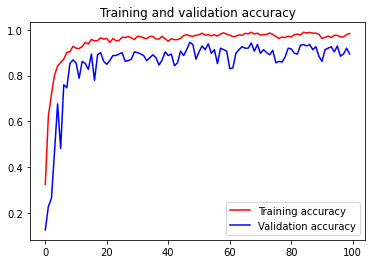

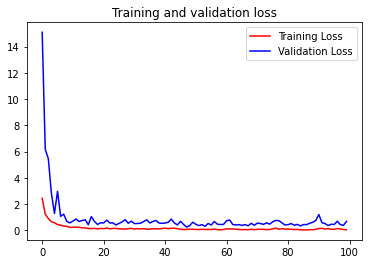

In [9]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 13, 13, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 256)       295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 256)        0   

# Testing 2 (Same with 1,but with Dropout 0.2) 

In [11]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras import regularizers
from keras.constraints import max_norm

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("Validation accuracy is reach 98% cancel training")
            self.model.stop_training = True

entry = L.Input(shape=(28,28,3))
x = L.Conv2D(128,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Conv2D(256,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Conv2D(512,(2,2),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Flatten()(x)

x = L.Dropout(0.2)(x)
x = L.Dense(256)(x)
x = L.ReLU()(x)
x = L.Dense(128)(x)
x = L.ReLU()(x)
x = L.Dense(26,activation='softmax')(x)

callbacks = myCallback()
model = Model(entry,x)
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,callbacks],
                              verbose=1)

Epoch 1/100
39/39 [==============================] - 8s 187ms/step - loss: 2.4343 - accuracy: 0.2973 - val_loss: 15.7889 - val_accuracy: 0.1346
Epoch 2/100
39/39 [==============================] - 7s 180ms/step - loss: 1.4453 - accuracy: 0.5593 - val_loss: 6.1114 - val_accuracy: 0.2276
Epoch 3/100
39/39 [==============================] - 7s 182ms/step - loss: 0.9796 - accuracy: 0.7011 - val_loss: 3.0067 - val_accuracy: 0.4103
Epoch 4/100
39/39 [==============================] - 7s 176ms/step - loss: 0.7004 - accuracy: 0.7700 - val_loss: 3.2955 - val_accuracy: 0.4968
Epoch 5/100
39/39 [==============================] - 7s 178ms/step - loss: 0.5879 - accuracy: 0.8205 - val_loss: 1.7885 - val_accuracy: 0.6090
Epoch 6/100
39/39 [==============================] - 7s 180ms/step - loss: 0.4967 - accuracy: 0.8397 - val_loss: 1.6101 - val_accuracy: 0.6282
Epoch 7/100
39/39 [==============================] - 7s 182ms/step - loss: 0.4684 - accuracy: 0.8486 - val_loss: 1.2270 - val_accuracy: 0.666

Epoch 58/100
39/39 [==============================] - 6s 160ms/step - loss: 0.1440 - accuracy: 0.9623 - val_loss: 0.7539 - val_accuracy: 0.8365
Epoch 59/100
39/39 [==============================] - 6s 164ms/step - loss: 0.1084 - accuracy: 0.9663 - val_loss: 0.4095 - val_accuracy: 0.9038
Epoch 60/100
39/39 [==============================] - 6s 163ms/step - loss: 0.0980 - accuracy: 0.9720 - val_loss: 0.6215 - val_accuracy: 0.8846
Epoch 61/100
39/39 [==============================] - 6s 163ms/step - loss: 0.0911 - accuracy: 0.9712 - val_loss: 0.3811 - val_accuracy: 0.9199
Epoch 62/100
39/39 [==============================] - 6s 162ms/step - loss: 0.0715 - accuracy: 0.9784 - val_loss: 0.4576 - val_accuracy: 0.9263
Epoch 63/100
39/39 [==============================] - 7s 189ms/step - loss: 0.0742 - accuracy: 0.9800 - val_loss: 0.2687 - val_accuracy: 0.9231
Epoch 64/100
39/39 [==============================] - 6s 161ms/step - loss: 0.0358 - accuracy: 0.9880 - val_loss: 0.4967 - val_accuracy:

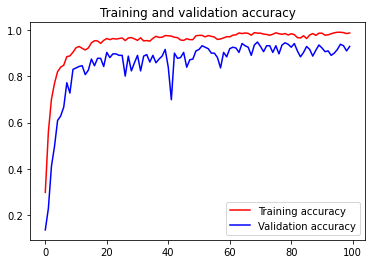

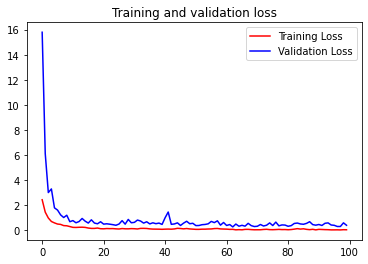

In [12]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 128)       3584      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 13, 13, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 256)       295168    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 256)        0   

# Testing 3 (Using 0.3 Dropout)

In [14]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras import regularizers
from keras.constraints import max_norm

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("Validation accuracy is reach 98% cancel training")
            self.model.stop_training = True

entry = L.Input(shape=(28,28,3))
x = L.Conv2D(128,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Conv2D(256,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Conv2D(512,(2,2),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Flatten()(x)

x = L.Dropout(0.3)(x)
x = L.Dense(256)(x)
x = L.ReLU()(x)
x = L.Dense(128)(x)
x = L.ReLU()(x)
x = L.Dense(26,activation='softmax')(x)

callbacks = myCallback()
model = Model(entry,x)
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,callbacks],
                              verbose=1)

Epoch 1/100
39/39 [==============================] - 8s 181ms/step - loss: 2.5221 - accuracy: 0.2869 - val_loss: 23.8891 - val_accuracy: 0.0673
Epoch 2/100
39/39 [==============================] - 7s 179ms/step - loss: 1.5039 - accuracy: 0.5553 - val_loss: 6.6042 - val_accuracy: 0.1314
Epoch 3/100
39/39 [==============================] - 7s 179ms/step - loss: 1.0402 - accuracy: 0.6939 - val_loss: 4.8245 - val_accuracy: 0.2436
Epoch 4/100
39/39 [==============================] - 7s 179ms/step - loss: 0.7782 - accuracy: 0.7644 - val_loss: 2.6232 - val_accuracy: 0.5321
Epoch 5/100
39/39 [==============================] - 7s 175ms/step - loss: 0.7523 - accuracy: 0.7692 - val_loss: 1.8013 - val_accuracy: 0.5673
Epoch 6/100
39/39 [==============================] - 7s 181ms/step - loss: 0.5297 - accuracy: 0.8277 - val_loss: 1.0830 - val_accuracy: 0.7756
Epoch 7/100
39/39 [==============================] - 7s 176ms/step - loss: 0.5030 - accuracy: 0.8397 - val_loss: 0.9624 - val_accuracy: 0.788

Epoch 58/100
39/39 [==============================] - 7s 166ms/step - loss: 0.0750 - accuracy: 0.9744 - val_loss: 0.5068 - val_accuracy: 0.9167
Epoch 59/100
39/39 [==============================] - 7s 176ms/step - loss: 0.0700 - accuracy: 0.9744 - val_loss: 0.8838 - val_accuracy: 0.8782
Epoch 60/100
39/39 [==============================] - 6s 161ms/step - loss: 0.1006 - accuracy: 0.9704 - val_loss: 0.6035 - val_accuracy: 0.9167
Epoch 61/100
39/39 [==============================] - 6s 162ms/step - loss: 0.0714 - accuracy: 0.9768 - val_loss: 0.4146 - val_accuracy: 0.9135
Epoch 62/100
39/39 [==============================] - 6s 162ms/step - loss: 0.1075 - accuracy: 0.9744 - val_loss: 0.4238 - val_accuracy: 0.9327
Epoch 63/100
39/39 [==============================] - 6s 160ms/step - loss: 0.0746 - accuracy: 0.9704 - val_loss: 0.4969 - val_accuracy: 0.9071
Epoch 64/100
39/39 [==============================] - 6s 160ms/step - loss: 0.0974 - accuracy: 0.9736 - val_loss: 0.6566 - val_accuracy:

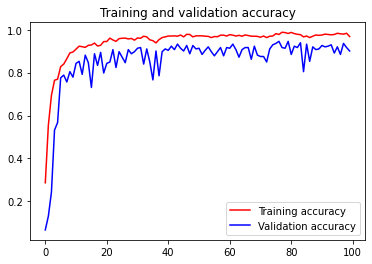

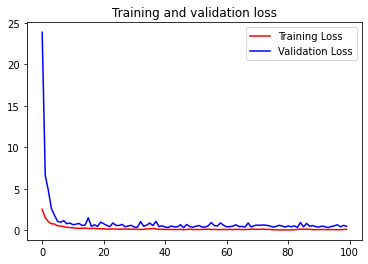

In [15]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 128)       3584      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 13, 13, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 256)       295168    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 5, 5, 256)        0   

# Testing 4 (Using 0.4 Dropout)

In [17]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras import regularizers
from keras.constraints import max_norm

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("Validation accuracy is reach 98% cancel training")
            self.model.stop_training = True

entry = L.Input(shape=(28,28,3))
x = L.Conv2D(128,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Conv2D(256,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Conv2D(512,(2,2),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Flatten()(x)

x = L.Dropout(0.3)(x)
x = L.Dense(256)(x)
x = L.ReLU()(x)
x = L.Dense(128)(x)
x = L.ReLU()(x)
x = L.Dense(26,activation='softmax')(x)

callbacks = myCallback()
model = Model(entry,x)
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,callbacks],
                              verbose=1)

Epoch 1/100
39/39 [==============================] - 8s 183ms/step - loss: 2.6088 - accuracy: 0.2604 - val_loss: 13.1091 - val_accuracy: 0.1282
Epoch 2/100
39/39 [==============================] - 7s 180ms/step - loss: 1.5471 - accuracy: 0.5545 - val_loss: 5.3002 - val_accuracy: 0.2660
Epoch 3/100
39/39 [==============================] - 7s 179ms/step - loss: 1.0490 - accuracy: 0.6803 - val_loss: 3.8964 - val_accuracy: 0.3429
Epoch 4/100
39/39 [==============================] - 7s 186ms/step - loss: 0.7852 - accuracy: 0.7556 - val_loss: 2.1860 - val_accuracy: 0.5160
Epoch 5/100
39/39 [==============================] - 7s 177ms/step - loss: 0.6619 - accuracy: 0.7965 - val_loss: 1.4224 - val_accuracy: 0.6667
Epoch 6/100
39/39 [==============================] - 7s 172ms/step - loss: 0.5057 - accuracy: 0.8510 - val_loss: 1.8154 - val_accuracy: 0.6635
Epoch 7/100
39/39 [==============================] - 7s 167ms/step - loss: 0.5075 - accuracy: 0.8510 - val_loss: 1.5245 - val_accuracy: 0.721

Epoch 58/100
39/39 [==============================] - 6s 163ms/step - loss: 0.0909 - accuracy: 0.9704 - val_loss: 1.2356 - val_accuracy: 0.8013
Epoch 59/100
39/39 [==============================] - 7s 166ms/step - loss: 0.0999 - accuracy: 0.9728 - val_loss: 0.4930 - val_accuracy: 0.9231
Epoch 60/100
39/39 [==============================] - 6s 165ms/step - loss: 0.0971 - accuracy: 0.9696 - val_loss: 0.5222 - val_accuracy: 0.9103
Epoch 61/100
39/39 [==============================] - 6s 164ms/step - loss: 0.1326 - accuracy: 0.9639 - val_loss: 0.5983 - val_accuracy: 0.9071
Epoch 62/100
39/39 [==============================] - 6s 163ms/step - loss: 0.0929 - accuracy: 0.9696 - val_loss: 0.4283 - val_accuracy: 0.9295
Epoch 63/100
39/39 [==============================] - 6s 162ms/step - loss: 0.0766 - accuracy: 0.9736 - val_loss: 0.6527 - val_accuracy: 0.8942
Epoch 64/100
39/39 [==============================] - 7s 166ms/step - loss: 0.0982 - accuracy: 0.9679 - val_loss: 0.9734 - val_accuracy:

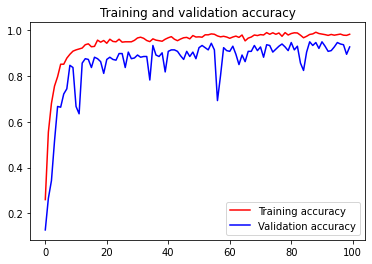

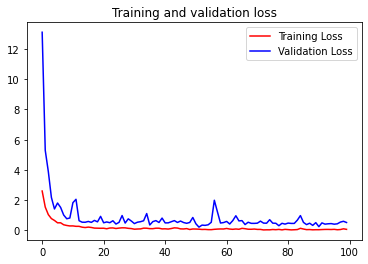

In [18]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 128)       3584      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 13, 13, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 256)       295168    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 256)        0   

# Testing 5 (Using SeparableConv2D & Flatten)

In [20]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras import regularizers
from keras.constraints import max_norm


model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("Validation accuracy is reach 98% cancel training")
            self.model.stop_training = True

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(128,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(256,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(512,(2,2),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.Flatten()(x)

x = L.Dropout(0.3)(x)
x = L.Dense(256)(x)
x = L.ReLU()(x)
x = L.Dense(128)(x)
x = L.ReLU()(x)
x = L.Dense(26,activation='softmax')(x)

callbacks = myCallback()
model = Model(entry,x)
#opt=Adam(0.001)
#opt1 = SGD(learning_rate = 0.001)
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,callbacks],
                              verbose=1)

Epoch 1/100
39/39 [==============================] - 5s 105ms/step - loss: 2.5177 - accuracy: 0.2804 - val_loss: 3.2334 - val_accuracy: 0.1442
Epoch 2/100
39/39 [==============================] - 4s 97ms/step - loss: 1.3486 - accuracy: 0.5873 - val_loss: 3.1837 - val_accuracy: 0.1635
Epoch 3/100
39/39 [==============================] - 4s 96ms/step - loss: 0.9750 - accuracy: 0.6811 - val_loss: 3.1233 - val_accuracy: 0.1955
Epoch 4/100
39/39 [==============================] - 4s 90ms/step - loss: 0.6740 - accuracy: 0.8021 - val_loss: 3.0706 - val_accuracy: 0.1186
Epoch 5/100
39/39 [==============================] - 4s 94ms/step - loss: 0.5517 - accuracy: 0.8357 - val_loss: 2.9718 - val_accuracy: 0.1122
Epoch 6/100
39/39 [==============================] - 4s 91ms/step - loss: 0.4557 - accuracy: 0.8558 - val_loss: 2.7619 - val_accuracy: 0.2115
Epoch 7/100
39/39 [==============================] - 4s 92ms/step - loss: 0.4002 - accuracy: 0.8726 - val_loss: 2.5612 - val_accuracy: 0.3397
Epoch

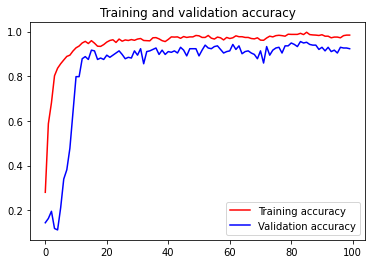

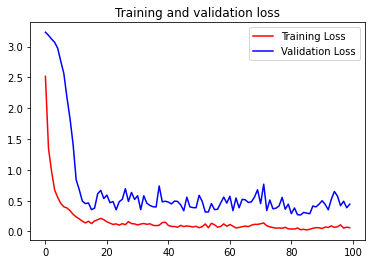

In [21]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d (Separable  (None, 26, 26, 128)      539       
 Conv2D)                                                         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 13, 13, 128)      512       
 chNormalization)                                                
                                                                 
 separable_conv2d_1 (Separab  (None, 11, 11, 256)      34176     
 leConv2D)                                                 

# Testing 6(Using SeparableConv2D and GlobalMaxPooling2D)

In [23]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras import regularizers
from keras.constraints import max_norm


model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("Validation accuracy is reach 98% cancel training")
            self.model.stop_training = True

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(128,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(256,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(512,(2,2),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.GlobalMaxPooling2D()(x)

x = L.Dropout(0.3)(x)
x = L.Dense(256)(x)
x = L.ReLU()(x)
x = L.Dense(128)(x)
x = L.ReLU()(x)
x = L.Dense(26,activation='softmax')(x)

callbacks = myCallback()
model = Model(entry,x)
#opt=Adam(0.001)
#opt1 = SGD(learning_rate = 0.001)
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,callbacks],
                              verbose=1)

Epoch 1/100
39/39 [==============================] - 4s 93ms/step - loss: 3.2326 - accuracy: 0.0889 - val_loss: 3.2513 - val_accuracy: 0.0513
Epoch 2/100
39/39 [==============================] - 4s 89ms/step - loss: 2.6215 - accuracy: 0.2188 - val_loss: 3.2362 - val_accuracy: 0.0641
Epoch 3/100
39/39 [==============================] - 4s 92ms/step - loss: 2.0840 - accuracy: 0.3990 - val_loss: 3.2229 - val_accuracy: 0.0449
Epoch 4/100
39/39 [==============================] - 4s 89ms/step - loss: 1.5192 - accuracy: 0.5465 - val_loss: 3.1862 - val_accuracy: 0.0481
Epoch 5/100
39/39 [==============================] - 3s 86ms/step - loss: 1.2523 - accuracy: 0.6258 - val_loss: 3.1432 - val_accuracy: 0.0705
Epoch 6/100
39/39 [==============================] - 3s 86ms/step - loss: 1.0504 - accuracy: 0.6771 - val_loss: 3.0505 - val_accuracy: 0.1474
Epoch 7/100
39/39 [==============================] - 3s 85ms/step - loss: 0.8755 - accuracy: 0.7220 - val_loss: 2.9140 - val_accuracy: 0.1827
Epoch 

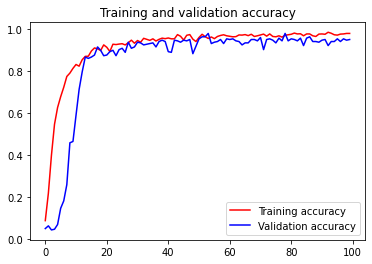

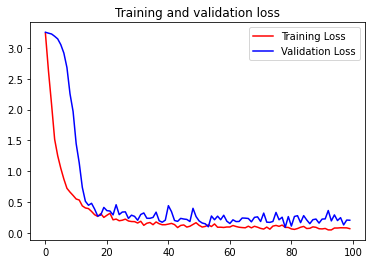

In [24]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d_3 (Separab  (None, 26, 26, 128)      539       
 leConv2D)                                                       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 13, 13, 128)      512       
 chNormalization)                                                
                                                                 
 separable_conv2d_4 (Separab  (None, 11, 11, 256)      34176     
 leConv2D)                                                 

# Testing 7 (using 0.0001 learning rate)

In [4]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras import regularizers
from keras.constraints import max_norm

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("Validation accuracy is reach 98% cancel training")
            self.model.stop_training = True

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(128,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(256,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(512,(2,2),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.GlobalMaxPooling2D()(x)

x = L.Dropout(0.3)(x)
x = L.Dense(256)(x)
x = L.ReLU()(x)
x = L.Dense(128)(x)
x = L.ReLU()(x)
x = L.Dense(26,activation='softmax')(x)

callbacks = myCallback()
model = Model(entry,x)
opt=Adam(0.0001)
#opt1 = SGD(learning_rate = 0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,callbacks],
                              verbose=1)

Epoch 1/100
39/39 [==============================] - 8s 179ms/step - loss: 3.4805 - accuracy: 0.0481 - val_loss: 3.2569 - val_accuracy: 0.0449
Epoch 2/100
39/39 [==============================] - 3s 88ms/step - loss: 3.2421 - accuracy: 0.0737 - val_loss: 3.2561 - val_accuracy: 0.0481
Epoch 3/100
39/39 [==============================] - 4s 98ms/step - loss: 3.1222 - accuracy: 0.1058 - val_loss: 3.2549 - val_accuracy: 0.0449
Epoch 4/100
39/39 [==============================] - 3s 84ms/step - loss: 3.0253 - accuracy: 0.1370 - val_loss: 3.2513 - val_accuracy: 0.0417
Epoch 5/100
39/39 [==============================] - 4s 100ms/step - loss: 2.9075 - accuracy: 0.1554 - val_loss: 3.2446 - val_accuracy: 0.0513
Epoch 6/100
39/39 [==============================] - 4s 99ms/step - loss: 2.8379 - accuracy: 0.1587 - val_loss: 3.2313 - val_accuracy: 0.0577
Epoch 7/100
39/39 [==============================] - 4s 97ms/step - loss: 2.7079 - accuracy: 0.2091 - val_loss: 3.2105 - val_accuracy: 0.0801
Epoc

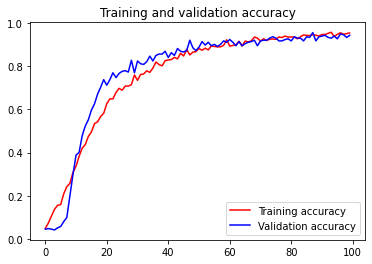

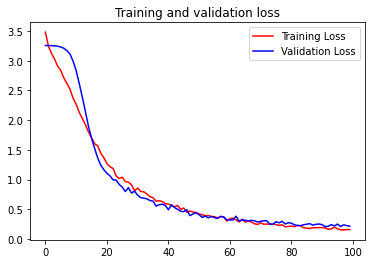

In [5]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d (Separable  (None, 26, 26, 128)      539       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 128)      512       
 ormalization)                                                   
                                                                 
 separable_conv2d_1 (Separab  (None, 11, 11, 256)      34176     
 leConv2D)                                                   

# Testing 8 (Using 0.001 learning rate (default optimizer adam)) 

In [4]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras import regularizers
from keras.constraints import max_norm

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("Validation accuracy is reach 98% cancel training")
            self.model.stop_training = True

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(128,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(256,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(512,(2,2),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.GlobalMaxPooling2D()(x)

x = L.Dropout(0.3)(x)
x = L.Dense(256)(x)
x = L.ReLU()(x)
x = L.Dense(128)(x)
x = L.ReLU()(x)
x = L.Dense(26,activation='softmax')(x)

callbacks = myCallback()
model = Model(entry,x)
opt=Adam(0.001)
#opt1 = SGD(learning_rate = 0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,callbacks],
                              verbose=1)

Epoch 1/100
39/39 [==============================] - 8s 171ms/step - loss: 3.2101 - accuracy: 0.1066 - val_loss: 3.2519 - val_accuracy: 0.0641
Epoch 2/100
39/39 [==============================] - 3s 81ms/step - loss: 2.5859 - accuracy: 0.2484 - val_loss: 3.2423 - val_accuracy: 0.0385
Epoch 3/100
39/39 [==============================] - 3s 80ms/step - loss: 1.9649 - accuracy: 0.3926 - val_loss: 3.2478 - val_accuracy: 0.0417
Epoch 4/100
39/39 [==============================] - 3s 79ms/step - loss: 1.5120 - accuracy: 0.5417 - val_loss: 3.2614 - val_accuracy: 0.0385
Epoch 5/100
39/39 [==============================] - 3s 79ms/step - loss: 1.1997 - accuracy: 0.6034 - val_loss: 3.2937 - val_accuracy: 0.0417
Epoch 6/100
39/39 [==============================] - 3s 79ms/step - loss: 1.0094 - accuracy: 0.6859 - val_loss: 3.2309 - val_accuracy: 0.0513
Epoch 7/100
39/39 [==============================] - 3s 79ms/step - loss: 0.8120 - accuracy: 0.7308 - val_loss: 3.2750 - val_accuracy: 0.0513
Epoch

39/39 [==============================] - 3s 78ms/step - loss: 0.0994 - accuracy: 0.9655 - val_loss: 0.1598 - val_accuracy: 0.9455
Epoch 59/100
39/39 [==============================] - 3s 82ms/step - loss: 0.1270 - accuracy: 0.9591 - val_loss: 0.2215 - val_accuracy: 0.9263
Epoch 60/100
39/39 [==============================] - 3s 79ms/step - loss: 0.1016 - accuracy: 0.9663 - val_loss: 0.2048 - val_accuracy: 0.9487
Epoch 61/100
39/39 [==============================] - 3s 78ms/step - loss: 0.0945 - accuracy: 0.9720 - val_loss: 0.1548 - val_accuracy: 0.9583
Epoch 62/100
39/39 [==============================] - 3s 79ms/step - loss: 0.1169 - accuracy: 0.9615 - val_loss: 0.2183 - val_accuracy: 0.9423
Epoch 63/100
39/39 [==============================] - 3s 79ms/step - loss: 0.1243 - accuracy: 0.9599 - val_loss: 0.2162 - val_accuracy: 0.9519
Epoch 64/100
39/39 [==============================] - 3s 80ms/step - loss: 0.1056 - accuracy: 0.9647 - val_loss: 0.2192 - val_accuracy: 0.9423
Epoch 65/100

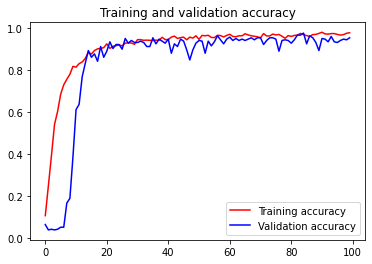

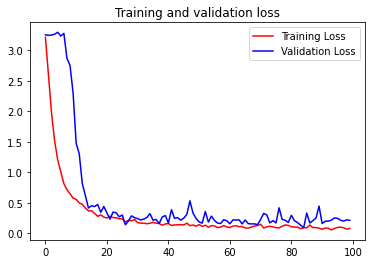

In [5]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d_9 (Separab  (None, 26, 26, 128)      539       
 leConv2D)                                                       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 13, 13, 128)      512       
 chNormalization)                                                
                                                                 
 separable_conv2d_10 (Separa  (None, 11, 11, 256)      34176     
 bleConv2D)                                                

# Testing 9 (Using 0.01 learning rate)

In [32]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras import regularizers
from keras.constraints import max_norm

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("Validation accuracy is reach 98% cancel training")
            self.model.stop_training = True

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(128,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(256,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(512,(2,2),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.GlobalMaxPooling2D()(x)

x = L.Dropout(0.3)(x)
x = L.Dense(256)(x)
x = L.ReLU()(x)
x = L.Dense(128)(x)
x = L.ReLU()(x)
x = L.Dense(26,activation='softmax')(x)

callbacks = myCallback()
model = Model(entry,x)
opt=Adam(0.01)
#opt1 = SGD(learning_rate = 0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,callbacks],
                              verbose=1)

Epoch 1/100
39/39 [==============================] - 5s 98ms/step - loss: 3.6065 - accuracy: 0.0649 - val_loss: 3.4176 - val_accuracy: 0.0449
Epoch 2/100
39/39 [==============================] - 3s 89ms/step - loss: 2.9527 - accuracy: 0.1018 - val_loss: 4.1360 - val_accuracy: 0.0321
Epoch 3/100
39/39 [==============================] - 3s 88ms/step - loss: 2.7382 - accuracy: 0.1226 - val_loss: 3.6709 - val_accuracy: 0.0609
Epoch 4/100
39/39 [==============================] - 4s 93ms/step - loss: 2.5147 - accuracy: 0.1971 - val_loss: 2.9531 - val_accuracy: 0.1026
Epoch 5/100
39/39 [==============================] - 3s 87ms/step - loss: 2.3233 - accuracy: 0.2620 - val_loss: 6.1704 - val_accuracy: 0.0962
Epoch 6/100
39/39 [==============================] - 4s 91ms/step - loss: 2.0010 - accuracy: 0.3317 - val_loss: 2.1547 - val_accuracy: 0.2917
Epoch 7/100
39/39 [==============================] - 3s 85ms/step - loss: 1.9205 - accuracy: 0.3766 - val_loss: 2.9569 - val_accuracy: 0.3237
Epoch 

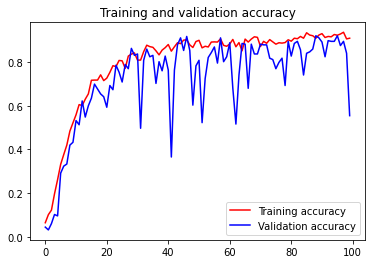

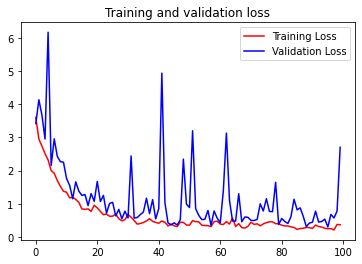

In [33]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d_12 (Separa  (None, 26, 26, 128)      539       
 bleConv2D)                                                      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_27 (Bat  (None, 13, 13, 128)      512       
 chNormalization)                                                
                                                                 
 separable_conv2d_13 (Separa  (None, 11, 11, 256)      34176     
 bleConv2D)                                                

# Testing 10 (Using ReduceLROnPlateu with 0.001 learning rate)

In [35]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras import regularizers
from keras.constraints import max_norm


model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("Validation accuracy is reach 98% cancel training")
            self.model.stop_training = True

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(128,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(256,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(512,(2,2),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.GlobalMaxPooling2D()(x)

x = L.Dropout(0.3)(x)
x = L.Dense(256)(x)
x = L.ReLU()(x)
x = L.Dense(128)(x)
x = L.ReLU()(x)
x = L.Dense(26,activation='softmax')(x)

callbacks = myCallback()
model = Model(entry,x)
opt=Adam(0.001)
#opt1 = SGD(learning_rate = 0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,reduce_lr,callbacks],
                              verbose=1)

Epoch 1/100
39/39 [==============================] - 6s 124ms/step - loss: 3.2356 - accuracy: 0.0921 - val_loss: 3.2549 - val_accuracy: 0.0385 - lr: 0.0010
Epoch 2/100
39/39 [==============================] - 4s 111ms/step - loss: 2.6950 - accuracy: 0.2115 - val_loss: 3.2547 - val_accuracy: 0.0385 - lr: 0.0010
Epoch 3/100
39/39 [==============================] - 4s 102ms/step - loss: 2.1994 - accuracy: 0.3029 - val_loss: 3.2671 - val_accuracy: 0.0385 - lr: 0.0010
Epoch 4/100
39/39 [==============================] - 4s 105ms/step - loss: 1.6276 - accuracy: 0.4856 - val_loss: 3.3004 - val_accuracy: 0.0417 - lr: 0.0010
Epoch 5/100
39/39 [==============================] - 4s 105ms/step - loss: 1.2763 - accuracy: 0.6082 - val_loss: 3.3605 - val_accuracy: 0.0353 - lr: 0.0010
Epoch 6/100
39/39 [==============================] - 4s 107ms/step - loss: 0.9917 - accuracy: 0.6883 - val_loss: 3.3693 - val_accuracy: 0.0385 - lr: 0.0010
Epoch 7/100
39/39 [==============================] - 4s 110ms/st

Epoch 53/100
39/39 [==============================] - 4s 90ms/step - loss: 0.0468 - accuracy: 0.9880 - val_loss: 0.1202 - val_accuracy: 0.9487 - lr: 1.0000e-04
Epoch 54/100
39/39 [==============================] - 4s 92ms/step - loss: 0.0480 - accuracy: 0.9856 - val_loss: 0.0814 - val_accuracy: 0.9840 - lr: 1.0000e-04


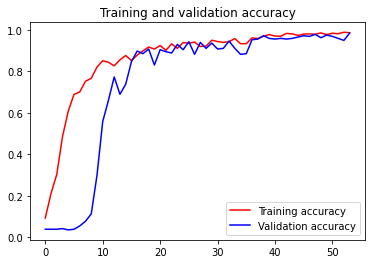

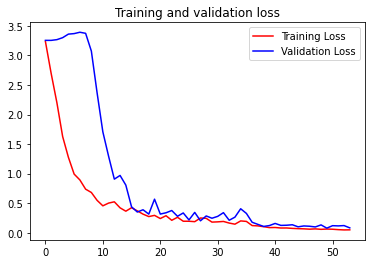

In [36]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d_15 (Separa  (None, 26, 26, 128)      539       
 bleConv2D)                                                      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 13, 13, 128)      512       
 chNormalization)                                                
                                                                 
 separable_conv2d_16 (Separa  (None, 11, 11, 256)      34176     
 bleConv2D)                                               

# Testing 11(using kernel_regularizer 0.00001)

In [6]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
from keras import regularizers
from keras.constraints import max_norm

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("Validation accuracy is reach 98% cancel training")
            self.model.stop_training = True

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(128,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(256,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.SeparableConv2D(512,(2,2),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.BatchNormalization()(x)

x = L.GlobalMaxPooling2D()(x)

x = L.Dropout(0.3)(x)
x = L.Dense(256)(x)
x = L.ReLU()(x)
x = L.Dense(128,kernel_regularizer=l2(1e-5))(x)
x = L.ReLU()(x)
x = L.Dense(26,activation='softmax')(x)

callbacks = myCallback()
model = Model(entry,x)
opt=Adam(0.001)
#opt1 = SGD(learning_rate = 0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=100,
                              callbacks=[model_ckpt,reduce_lr,callbacks],
                              verbose=1)

Epoch 1/100
39/39 [==============================] - 6s 141ms/step - loss: 3.2018 - accuracy: 0.1018 - val_loss: 3.2487 - val_accuracy: 0.0641 - lr: 0.0010
Epoch 2/100
39/39 [==============================] - 5s 129ms/step - loss: 2.4693 - accuracy: 0.2620 - val_loss: 3.2339 - val_accuracy: 0.0385 - lr: 0.0010
Epoch 3/100
39/39 [==============================] - 5s 124ms/step - loss: 1.8071 - accuracy: 0.4679 - val_loss: 3.2190 - val_accuracy: 0.0385 - lr: 0.0010
Epoch 4/100
39/39 [==============================] - 5s 120ms/step - loss: 1.2676 - accuracy: 0.5978 - val_loss: 3.2230 - val_accuracy: 0.0417 - lr: 0.0010
Epoch 5/100
39/39 [==============================] - 5s 121ms/step - loss: 1.0097 - accuracy: 0.6851 - val_loss: 3.2043 - val_accuracy: 0.0353 - lr: 0.0010
Epoch 6/100
39/39 [==============================] - 5s 140ms/step - loss: 0.7904 - accuracy: 0.7388 - val_loss: 3.0901 - val_accuracy: 0.0737 - lr: 0.0010
Epoch 7/100
39/39 [==============================] - 5s 133ms/st

Epoch 53/100
39/39 [==============================] - 5s 118ms/step - loss: 0.0863 - accuracy: 0.9760 - val_loss: 0.1483 - val_accuracy: 0.9423 - lr: 0.00100.0715 - accuracy: 0.97 - ETA: 0s - loss: 0.0
Epoch 54/100
39/39 [==============================] - 5s 122ms/step - loss: 0.1128 - accuracy: 0.9631 - val_loss: 0.1413 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 55/100
39/39 [==============================] - 6s 143ms/step - loss: 0.0937 - accuracy: 0.9688 - val_loss: 0.1872 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 56/100
39/39 [==============================] - 5s 134ms/step - loss: 0.1301 - accuracy: 0.9575 - val_loss: 0.4109 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 57/100
39/39 [==============================] - 5s 132ms/step - loss: 0.0963 - accuracy: 0.9655 - val_loss: 0.1276 - val_accuracy: 0.9487 - lr: 1.0000e-04
Epoch 58/100
39/39 [==============================] - 5s 119ms/step - loss: 0.0623 - accuracy: 0.9808 - val_loss: 0.1836 - val_accuracy: 0.9583 - lr: 1.0000e-04acy - 

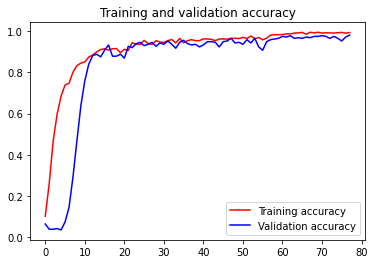

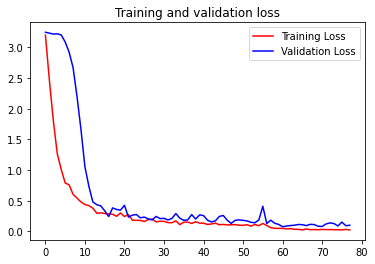

In [7]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d_18 (Separa  (None, 26, 26, 128)      539       
 bleConv2D)                                                      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_33 (Bat  (None, 13, 13, 128)      512       
 chNormalization)                                                
                                                                 
 separable_conv2d_19 (Separa  (None, 11, 11, 256)      34176     
 bleConv2D)                                               